Please refer to Ben Sadeghi's [post](https://mapr.com/blog/churn-prediction-pyspark-using-mllib-and-ml-packages/) for the complete tutorial. This is a mere update, as some lines of code, functions, dependencies, etc. did not work as of March 2018... Spark environment is moving fast!
So, for everyone's sake, read the main post first, then come back when you find yourself in trouble. 

Let's first import some of the needed libraries. We will, however, be importing libraries as we need them.

In [1]:
import pandas as pd
from pyspark.sql import SparkSession

### Starting a Spark session
Let's first start fresh with a brand-new SparkSession.

In [2]:
spark = SparkSession.builder\
    .master("local")\
    .appName("Churn Prediction")\
    .getOrCreate()

### Reading the data

Let's read the data, which is already split into training and test set.

In [3]:
train_data = spark.read.load("data/churn-bigml-80.csv",
                             format="com.databricks.spark.csv",
                             header="true",
                             inferSchema="true")

test_data = spark.read.load("data/churn-bigml-20.csv",
                            format="com.databricks.spark.csv",
                            header="true",
                            inferSchema="true")

### Data exploration and data wrangling

This train_data.printSchema() will give us some very important info.

In [4]:
train_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



Some column types are good news, some are bad.

We move the spark DataFrame out to a Pandas dataframe just because it looks prettier when printed out. So we can get a feel of how our data is.

In [5]:
pd.DataFrame(train_data.take(5), columns=train_data.columns).transpose()

,0,1,2,3,4
State,KS,OH,NJ,OH,OK
Account length,128,107,137,84,75
Area code,415,415,415,408,415
International plan,No,No,No,Yes,Yes
Voice mail plan,Yes,Yes,No,No,No
Number vmail messages,25,26,0,0,0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110,123,114,71,113
Total day charge,45.07,27.47,41.38,50.9,28.34
Total eve minutes,197.4,195.5,121.2,61.9,148.3


This are some summary statistics on our data.

In [6]:
train_data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
State,2666,None,None,AK,WY
Account length,2666,100.62040510127532,39.56397365334985,1,243
Area code,2666,437.43885971492875,42.521018019427174,408,510
International plan,2666,None,None,No,Yes
Voice mail plan,2666,None,None,No,Yes
Number vmail messages,2666,8.021755438859715,13.61227701829193,0,50
Total day minutes,2666,179.48162040510135,54.21035022086982,0.0,350.8
Total day calls,2666,100.31020255063765,19.988162186059512,0,160
Total day charge,2666,30.512404351087813,9.215732907163497,0.0,59.64


We now plot a bit! Please refer to the [original post](https://mapr.com/blog/churn-prediction-pyspark-using-mllib-and-ml-packages/) for explanation. It is OK if this piece of code takes a while to run!

In [7]:
import matplotlib.pyplot as plt

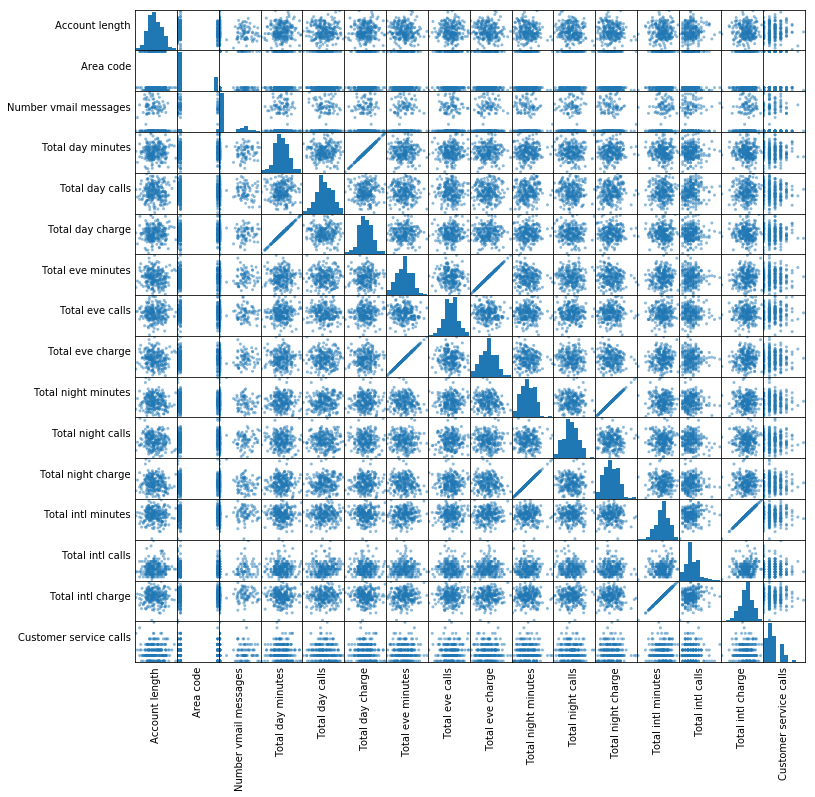

In [8]:
# Correlation analysis
numeric_features = [t[0] for t in
                    train_data.dtypes if t[1] == "int" or t[1] == "double"]

sampled_data = train_data.select(numeric_features) \
    .sample(False, 0.10).toPandas()

axs = pd.plotting.scatter_matrix(sampled_data, figsize=(12, 12))

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

So pretty! But we want to skip the obviously correlated features, and also change the "yes", "no", "true" and "false" to ones and zeros. We'll do that by droping some columns and changing some others.

In [9]:
from pyspark.sql.types import DoubleType

In [10]:
train_data = train_data.drop("State").drop("Area code") \
                       .drop("Total day charge").drop("Total eve charge") \
                       .drop("Total night charge").drop("Total intl charge") \
                       .withColumn("Churn",
                                   train_data["Churn"].cast(DoubleType())) \
                       .withColumn("International plan",
                                   train_data["International plan"]
                                   .cast("boolean").cast(DoubleType())) \
                       .withColumn("Voice mail plan",
                                   train_data["Voice mail plan"]
                                   .cast("boolean").cast(DoubleType()))

And let's not forget the test data.

In [11]:
test_data = test_data.drop("State").drop("Area code") \
                       .drop("Total day charge").drop("Total eve charge") \
                       .drop("Total night charge").drop("Total intl charge") \
                       .withColumn("Churn",
                                   test_data["Churn"].cast(DoubleType())) \
                       .withColumn("International plan",
                                   test_data["International plan"]
                                   .cast("boolean").cast(DoubleType())) \
                       .withColumn("Voice mail plan",
                                   test_data["Voice mail plan"]
                                   .cast("boolean").cast(DoubleType()))

This looks like this now:

In [12]:
pd.DataFrame(train_data.take(5), columns=train_data.columns).transpose()

,0,1,2,3,4
Account length,128.0,107.0,137.0,84.0,75.0
International plan,0.0,0.0,0.0,1.0,1.0
Voice mail plan,1.0,1.0,0.0,0.0,0.0
Number vmail messages,25.0,26.0,0.0,0.0,0.0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110.0,123.0,114.0,71.0,113.0
Total eve minutes,197.4,195.5,121.2,61.9,148.3
Total eve calls,99.0,103.0,110.0,88.0,122.0
Total night minutes,244.7,254.4,162.6,196.9,186.9
Total night calls,91.0,103.0,104.0,89.0,121.0


Please note that we are only explorating, getting summary statistics, plotting,... the training set.

### Machine Learning

Let's do some **machine learning** now. We will use the ML library from Spark (not the MLlib from spark).

In [34]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

From the original post: "The ML package needs data be put in a (label: Double, features: Vector) DataFrame format with correspondingly named fields. The vectorizeData() function below performs this formatting." In this case we'll be using the VectorAssembler function from pyspark.ml.feature.

In [14]:
vecAssembler = VectorAssembler(inputCols=['Account length',
                                          'International plan',
                                          'Voice mail plan',
                                          'Number vmail messages',
                                          'Total day minutes',
                                          'Total day calls',
                                          'Total eve minutes',
                                          'Total eve calls',
                                          'Total night minutes',
                                          'Total night calls',
                                          'Total intl minutes',
                                          'Total intl calls',
                                          'Customer service calls'],
                               outputCol="features")

In [22]:
df_train = vecAssembler.transform(train_data)

Note the "features" column that we just added, which includes all other features in one single array. We execute the former code just to see what vecAssembler will be doing; the actual work will be carried out with a pipeline wrapper.

In [17]:
pd.DataFrame(df_train.take(5), columns=df_train.columns).transpose()

,0,1,2,3,4
Account length,128,107,137,84,75
International plan,0,0,0,1,1
Voice mail plan,1,1,0,0,0
Number vmail messages,25,26,0,0,0
Total day minutes,265.1,161.6,243.4,299.4,166.7
Total day calls,110,123,114,71,113
Total eve minutes,197.4,195.5,121.2,61.9,148.3
Total eve calls,99,103,110,88,122
Total night minutes,244.7,254.4,162.6,196.9,186.9
Total night calls,91,103,104,89,121


### Training the model

First, we create the decision tree with the columns "Churn" as labels and "features" as features.

In [18]:
dt = DecisionTreeClassifier(labelCol="Churn", featuresCol="features")

This Pipeline chains vecAssembler (VectorAssembler) and dt (DecisionTreeClassifier).

In [21]:
pipeline = Pipeline(stages=[vecAssembler, dt])

We fit the data.

In [24]:
model = pipeline.fit(train_data)

### Making predictions

In [25]:
predictions = model.transform(test_data)

In [60]:
predictions.select("prediction", "Churn", "features").toPandas().head(20)

,prediction,Churn,features
0,0.0,0.0,"[117.0, 0.0, 0.0, 0.0, 184.5, 97.0, 351.6, 80...."
1,1.0,1.0,"[65.0, 0.0, 0.0, 0.0, 129.1, 137.0, 228.5, 83...."
2,1.0,1.0,"[161.0, 0.0, 0.0, 0.0, 332.9, 67.0, 317.8, 97...."
3,0.0,0.0,"[111.0, 0.0, 0.0, 0.0, 110.4, 103.0, 137.3, 10..."
4,0.0,0.0,"[49.0, 0.0, 0.0, 0.0, 119.3, 117.0, 215.1, 109..."
5,0.0,0.0,"[36.0, 0.0, 1.0, 30.0, 146.3, 128.0, 162.5, 80..."
6,0.0,0.0,"[65.0, 0.0, 0.0, 0.0, 211.3, 120.0, 162.6, 122..."
7,0.0,1.0,"[119.0, 0.0, 0.0, 0.0, 159.1, 114.0, 231.3, 11..."
8,0.0,0.0,"[10.0, 0.0, 0.0, 0.0, 186.1, 112.0, 190.2, 66...."
9,0.0,0.0,"[68.0, 0.0, 0.0, 0.0, 148.8, 70.0, 246.5, 164...."


We use Pandas only because I like the styling better.

### Evaluating the model

Unlike in the original post, we will be evaluating the model with a BinaryClassifierEvaluator rather than with a MulticlassClassifierEvaluator.

In [27]:
evaluator = BinaryClassificationEvaluator(
    labelCol="Churn", rawPredictionCol="prediction")

In [28]:
evaluator.evaluate(predictions)

0.8184302539565699

By default BinaryClassificationEvaluator gives the ROC Area Under the Curve.

### Improving the model

We can try to improve our model with a bit of parameter tuning. This will take a while.

In [47]:
paramGrid = ParamGridBuilder().addGrid(dt.maxDepth, [2,3,4,5,6,7]).build()

# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator, 
                          numFolds=3)

CV_model = crossval.fit(train_data)

We fetch the best model and print it:

In [48]:
tree_model = CV_model.bestModel.stages[1]
print(tree_model)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_422596b245d603704296) of depth 7 with 121 nodes


In [52]:
predictions_improved = CV_model.bestModel.transform(test_data)

In [59]:
predictions_improved.select("prediction", "Churn", "features").toPandas().head(20)

,prediction,Churn,features
0,0.0,0.0,"[117.0, 0.0, 0.0, 0.0, 184.5, 97.0, 351.6, 80...."
1,1.0,1.0,"[65.0, 0.0, 0.0, 0.0, 129.1, 137.0, 228.5, 83...."
2,1.0,1.0,"[161.0, 0.0, 0.0, 0.0, 332.9, 67.0, 317.8, 97...."
3,0.0,0.0,"[111.0, 0.0, 0.0, 0.0, 110.4, 103.0, 137.3, 10..."
4,0.0,0.0,"[49.0, 0.0, 0.0, 0.0, 119.3, 117.0, 215.1, 109..."
5,0.0,0.0,"[36.0, 0.0, 1.0, 30.0, 146.3, 128.0, 162.5, 80..."
6,0.0,0.0,"[65.0, 0.0, 0.0, 0.0, 211.3, 120.0, 162.6, 122..."
7,0.0,1.0,"[119.0, 0.0, 0.0, 0.0, 159.1, 114.0, 231.3, 11..."
8,0.0,0.0,"[10.0, 0.0, 0.0, 0.0, 186.1, 112.0, 190.2, 66...."
9,0.0,0.0,"[68.0, 0.0, 0.0, 0.0, 148.8, 70.0, 246.5, 164...."


In [54]:
evaluator.evaluate(predictions_improved)

0.8526683842473316

We did indeed improve our AUC ROC!

##### March 2018, Josep Anton Mir Tutusaus